# English-Braille Text OCR and Translation Model

## 1) Import and Misc Functions

In [1]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#import seaborn as sns  #Unused import
import os
#from symspellpy import SymSpell, Verbosity
import pkg_resources

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (Dense, Dropout, Conv2D, MaxPool2D, 
                                     BatchNormalization, Flatten, GlobalAveragePooling2D, Input,
                                     LSTM, Bidirectional, TimeDistributed, Reshape, Embedding)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, LearningRateScheduler, ReduceLROnPlateau
from tensorflow.keras.applications import EfficientNetB7, MobileNetV2, VGG19, DenseNet121

from tensorflow.keras.regularizers import l2

2024-12-26 02:02:06.960199: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1735149727.053781  588473 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1735149727.083187  588473 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-26 02:02:07.274463: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
def directory_to_df(path : str):
    """
    This function to retrieve all images from targeted folder in a file, the
    folder must be divided hirarchally in which each class contains its images individually.
    ________________________________________________________________________________________________
    Arguments-
    
    path: String -> the main folder directory that contains train/test folders
    
    ________________________________________________________________________________________________
    Return-
    
    DataFrame: contains the images path and label corresponding to every image
    """
    df = []
    chars = 'abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789!,#&()-$%;@[]^_`}{~+'
    for cls in os.listdir(path):
        cls_path = os.path.join(path,cls)
        cls_name = cls.split('_')[0]
        if not cls_name in chars:
            if cls_name == 'qmark':
                cls_name = '?'
            elif cls_name == 'dot':
                cls_name = '.'
            elif cls_name == 'colon':
                cls_name = ':'
            else:
                continue
        for img_path in os.listdir(cls_path):
            direct = os.path.join(cls_path,img_path)
            df.append([direct,cls_name])
    
    df = pd.DataFrame(df, columns=['image','label'])
    print("The number of samples found:",len(df))
    return df.copy()

def read_image(path):
    """
    Read an image from specified directory
    _____________________________________________________________
    Arguments:
    
    path: String -> a directory of the image
    _____________________________________________________________
    Return:
    
    image: numpy.array of the image
    """
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image

def show_image(img, label=None) -> None:
    """
    This function to display any image
    _________________________________________________________
    Arguements:
    
    img: numpy.array of N-D
    
    label: String -> the title/label added with the image, Default= None
    _________________________________________________________
    Return:
    
    plt.imshow()
    """
    plt.imshow(img, cmap='gray')
    plt.axis(False)
    plt.title(label)
    plt.show()
    
def clbck(model_name):
    # The function is defined to make the callbacks for training the models
    ERLY = EarlyStopping(patience=10, min_delta=0.01, start_from_epoch=10, verbose=1)
    RD = ReduceLROnPlateau(
        monitor='val_accuracy',
        factor=0.5,
        patience=3,
        verbose=1, 
        min_lr=1e-6, 
    )
    CHK = ModelCheckpoint(f'models/{model_name}_model.keras',verbose=1, save_best_only=True)
    return [ERLY,RD,CHK]

## 2) Select Model to be Used & other preferences

`MODEL_SEL`: Choose your preferred model. (CustomCnn is default)

In [15]:
# Pre-defined hyperparameters
IMG_SHAPE = (64, 64)
IMG_SIZE = (64, 64, 3)
BATCH_SIZE = 32
opt = Adam(learning_rate=0.0001, epsilon=1e-6)
loss = 'categorical_crossentropy'
EPOCHS = 50

# Model selection
# 1. EfficientNetB7
# 2. CustomCNN
MODEL_SEL = 'CustomCNN'
# MODEL_SEL = 'EfficientNetB7'

## 3) Reading & preparing the dataset

In [4]:
# Reading the dataset in dataframe 
main_path = 'data/raw/character_set3/'
df = directory_to_df(main_path)                   # convert the dataset into df of two columns
df.head()

The number of samples found: 186041


,image,label
0,data/raw/character_set3/y/Y_L_2132.png,y
1,data/raw/character_set3/y/Y_L_791.png,y
2,data/raw/character_set3/y/Y_L_1007.png,y
3,data/raw/character_set3/y/Y_L_493.png,y
4,data/raw/character_set3/y/Y_L_10.png,y


In [5]:
df['label'].value_counts()

label
I    3566
K    3566
M    3566
R    3566
T    3566
     ... 
,     209
;     194
%     184
$     174
-     173
Name: count, Length: 84, dtype: int64

3.1) Splitting the dataframe

In [6]:
# Splitting for training & testing (70,30 respectively)
X, y = df['image'], df['label']
X_train, X_test, y_train, y_test = train_test_split(X,y , test_size=0.30, random_state=41)
training_df = pd.concat((X_train,y_train), axis=1)
testing_df = pd.concat((X_test,y_test), axis=1)

In [7]:
# Splitting for training & validation (75,25 respectively) -> the training set size = 52.5%
X, y = training_df['image'], training_df['label']
X_train, X_valid, y_train, y_valid = train_test_split(X,y , test_size=0.25, random_state=41)
training_df = pd.concat((X_train,y_train), axis=1)
validation_df = pd.concat((X_valid,y_valid), axis=1)

3.2) Creating generators

In [8]:
# Creating generators
gen = ImageDataGenerator(
    rotation_range=0,
    shear_range=0,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0,
    brightness_range=[0.5, 1.5],
    fill_mode='nearest',
    dtype=np.int32,
)

gen2 = ImageDataGenerator(dtype=np.int32, fill_mode='nearest')
train_gen = gen.flow_from_dataframe(training_df, x_col='image',y_col='label', batch_size=BATCH_SIZE, 
                                   target_size=IMG_SHAPE)
valid_gen = gen2.flow_from_dataframe(validation_df, x_col='image', y_col='label', batch_size=BATCH_SIZE, 
                                        target_size=IMG_SHAPE, shuffle=False)
test_gen = gen2.flow_from_dataframe(testing_df, x_col='image', y_col='label', batch_size=BATCH_SIZE, 
                                       target_size=IMG_SHAPE, shuffle=False)

Found 97671 validated image filenames belonging to 84 classes.
Found 32557 validated image filenames belonging to 84 classes.
Found 55813 validated image filenames belonging to 84 classes.


In [9]:
# Making a mapping of the classes and the inverse for later processings
mapping = train_gen.class_indices
mapping_inverse = dict(map(lambda x: tuple(reversed(x)), mapping.items()))

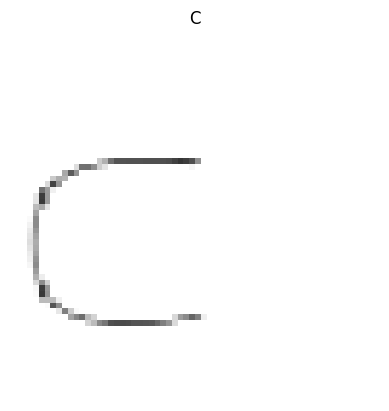

The shape of the image: (64, 64, 3)


In [10]:
# Reading a sample from the dataset
BATCH_NUM = 10
IMG_NUM = 2      # from 0 to 31
show_image(train_gen[BATCH_NUM][0][IMG_NUM],mapping_inverse[train_gen[BATCH_NUM][1][IMG_NUM].argmax()])
print('The shape of the image:',train_gen[BATCH_NUM][0][IMG_NUM].shape)

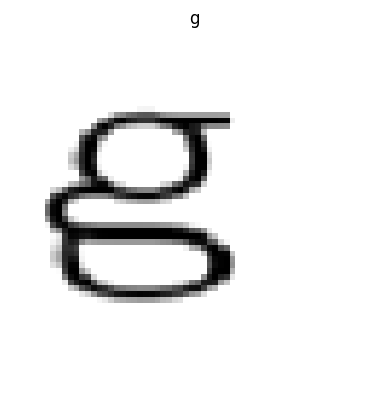

The shape of the image: (64, 64, 3)


In [11]:
# Reading another sample from the dataset
BATCH_NUM = 65
IMG_NUM = 30      # from 0 to 31
show_image(train_gen[BATCH_NUM][0][IMG_NUM],mapping_inverse[train_gen[BATCH_NUM][1][IMG_NUM].argmax()])
print('The shape of the image:',train_gen[BATCH_NUM][0][IMG_NUM].shape)

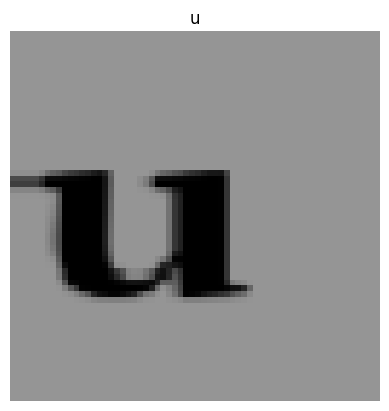

The shape of the image: (64, 64, 3)


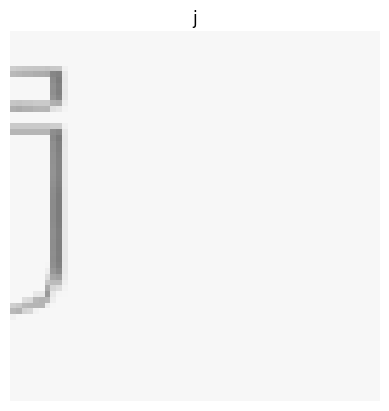

The shape of the image: (64, 64, 3)


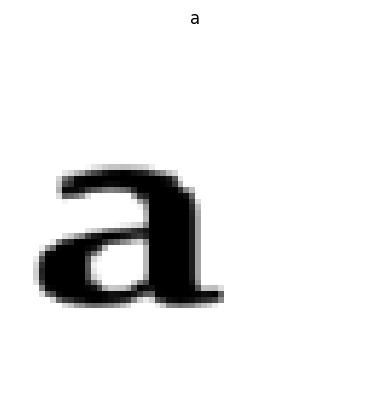

The shape of the image: (64, 64, 3)


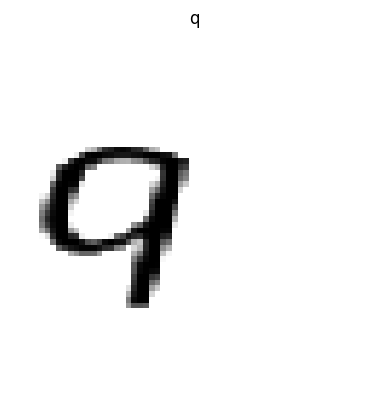

The shape of the image: (64, 64, 3)


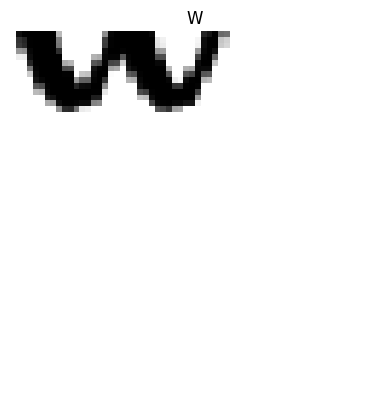

The shape of the image: (64, 64, 3)


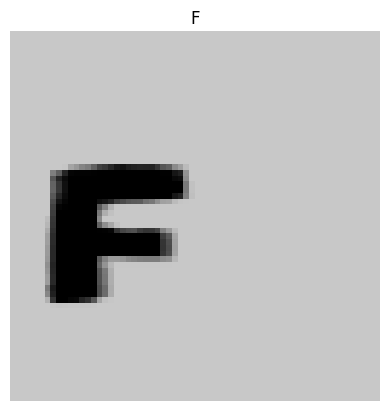

The shape of the image: (64, 64, 3)


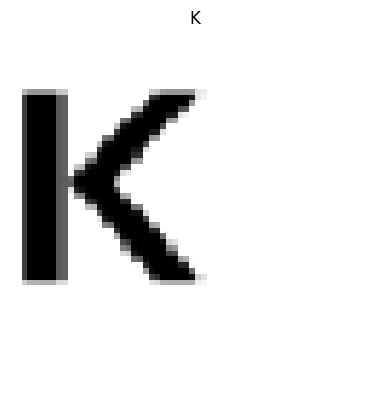

The shape of the image: (64, 64, 3)


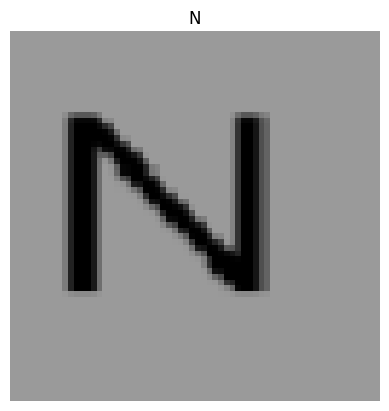

The shape of the image: (64, 64, 3)


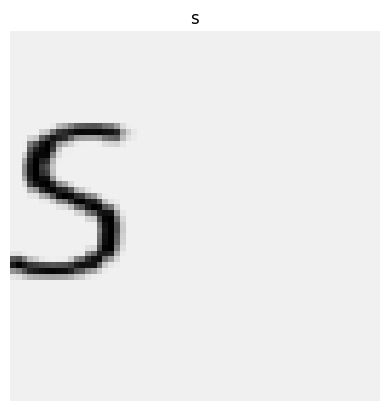

The shape of the image: (64, 64, 3)


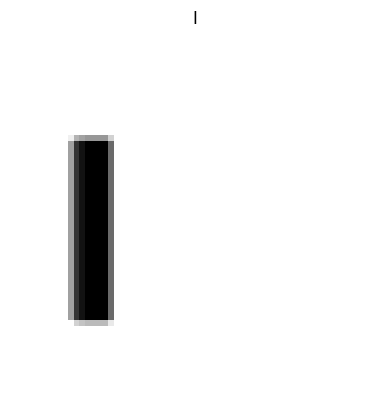

The shape of the image: (64, 64, 3)


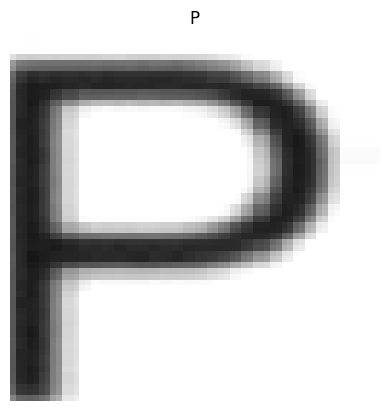

The shape of the image: (64, 64, 3)


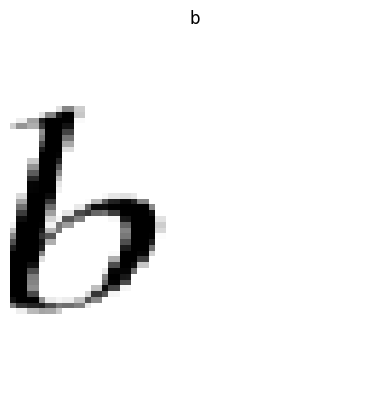

The shape of the image: (64, 64, 3)


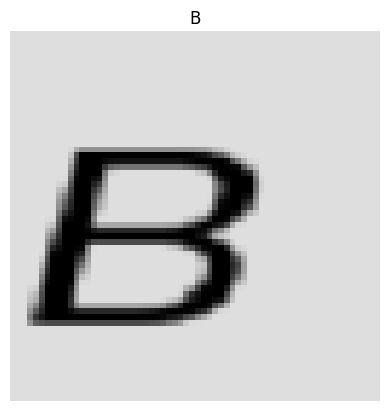

The shape of the image: (64, 64, 3)


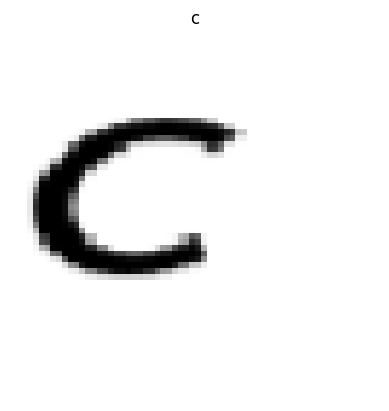

The shape of the image: (64, 64, 3)


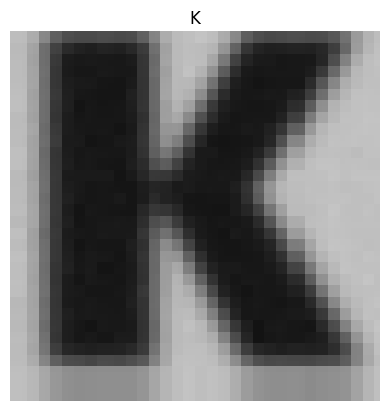

The shape of the image: (64, 64, 3)


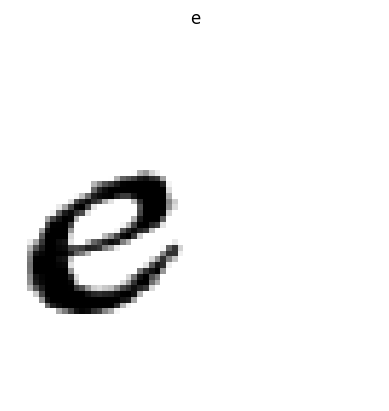

The shape of the image: (64, 64, 3)


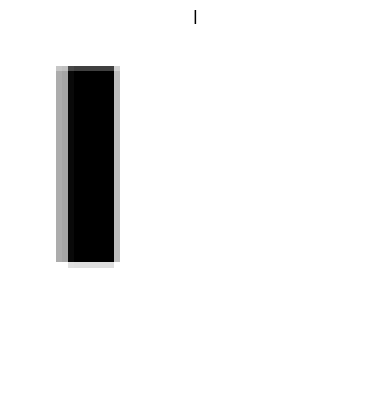

The shape of the image: (64, 64, 3)


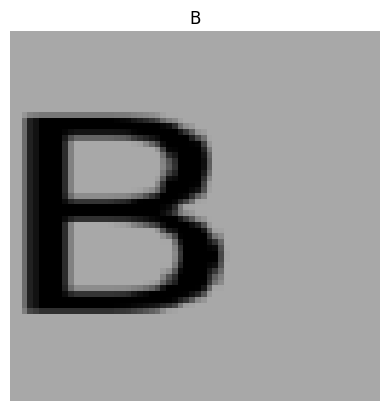

The shape of the image: (64, 64, 3)


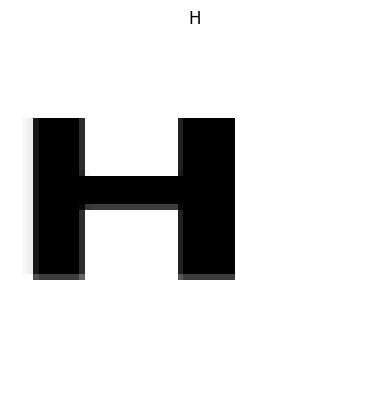

The shape of the image: (64, 64, 3)


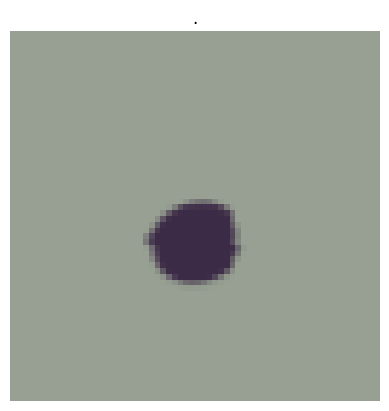

The shape of the image: (64, 64, 3)


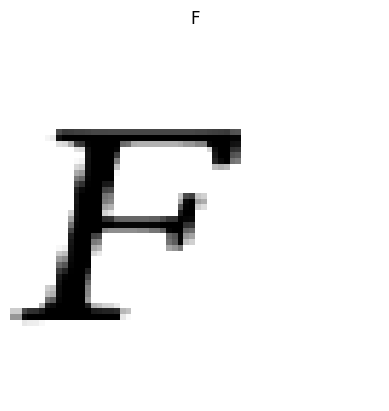

The shape of the image: (64, 64, 3)


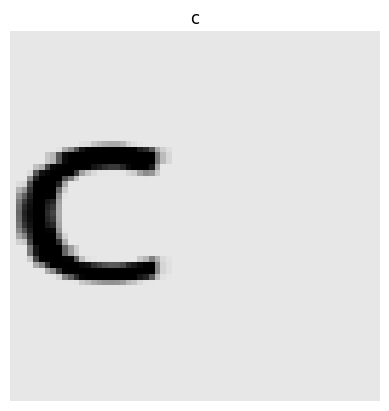

The shape of the image: (64, 64, 3)


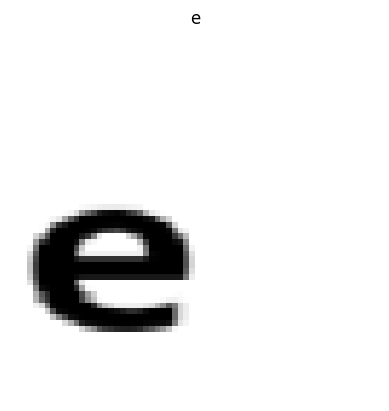

The shape of the image: (64, 64, 3)


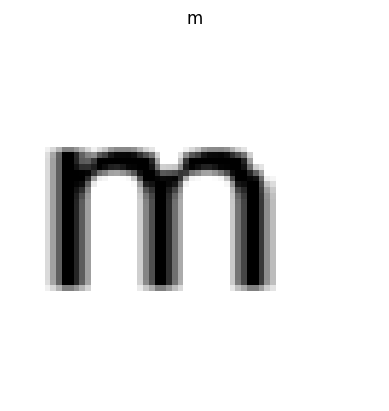

The shape of the image: (64, 64, 3)


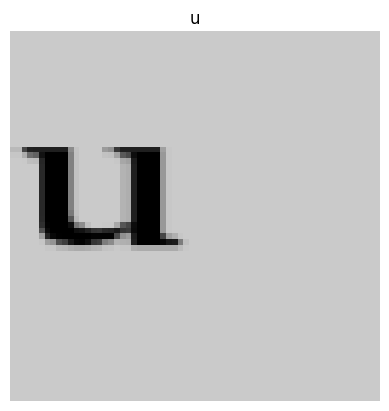

The shape of the image: (64, 64, 3)


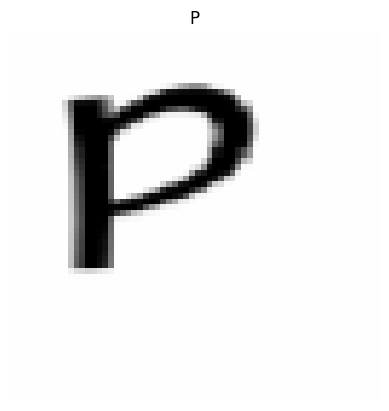

The shape of the image: (64, 64, 3)


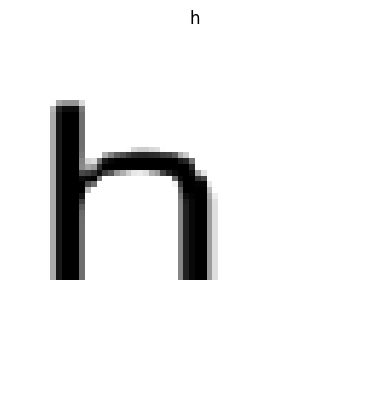

The shape of the image: (64, 64, 3)


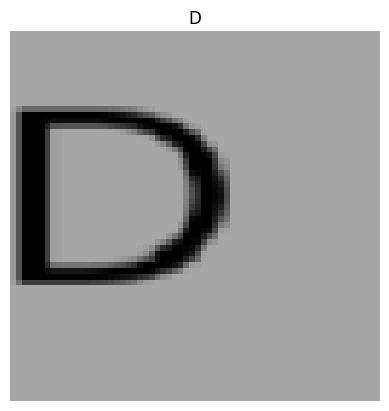

The shape of the image: (64, 64, 3)


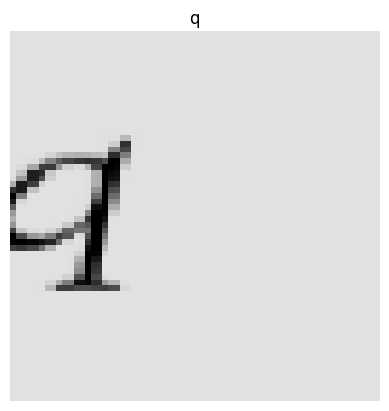

The shape of the image: (64, 64, 3)


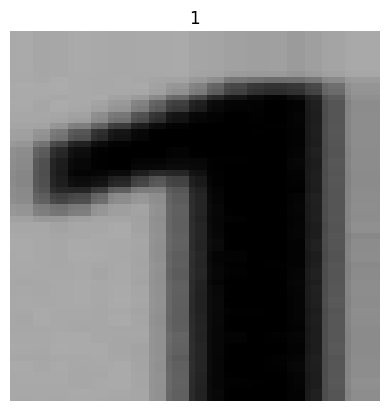

The shape of the image: (64, 64, 3)


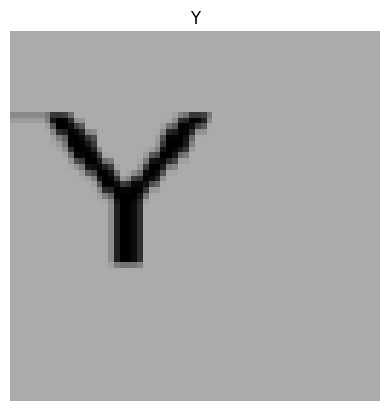

The shape of the image: (64, 64, 3)


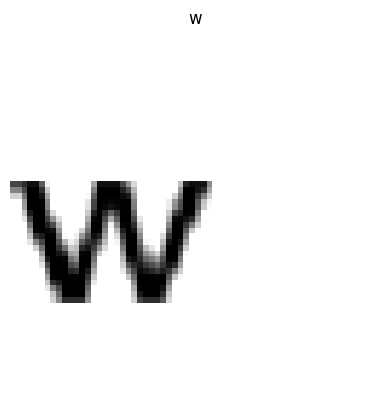

The shape of the image: (64, 64, 3)


In [12]:
BATCH_NUM = 0
IMG_NUM = 0      # from 0 to 31
for i in range(32):
    show_image(train_gen[BATCH_NUM][0][IMG_NUM+i],mapping_inverse[train_gen[BATCH_NUM][1][IMG_NUM+i].argmax()])
    print('The shape of the image:',train_gen[BATCH_NUM][0][IMG_NUM+i].shape)

# 4) Modeling

## 4.1) Custom Model

In [ ]:
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.regularizers import l2

CNN_model = Sequential()
CNN_model.add(Input(shape=IMG_SIZE, name='Input'))
CNN_model.add(Conv2D(32, (3,3), activation='relu', padding='same'))
CNN_model.add(BatchNormalization())
CNN_model.add(Conv2D(32, (3,3), activation='relu'))
CNN_model.add(BatchNormalization())
CNN_model.add(MaxPool2D((2,2)))
CNN_model.add(Dropout(0.25))

CNN_model.add(Conv2D(64, (3,3), activation='relu', padding='same'))
CNN_model.add(BatchNormalization())
CNN_model.add(Conv2D(64, (3,3), activation='relu'))
CNN_model.add(BatchNormalization())
CNN_model.add(MaxPool2D((2,2)))
CNN_model.add(Dropout(0.25))

CNN_model.add(Conv2D(128, (3,3), activation='relu', padding='same'))  # Added layer
CNN_model.add(BatchNormalization())
CNN_model.add(MaxPool2D((2,2)))
CNN_model.add(Dropout(0.25))

CNN_model.add(Flatten())
CNN_model.add(Dense(512, activation='relu', kernel_regularizer=l2(0.001)))  # Increased units
CNN_model.add(Dropout(0.5))
CNN_model.add(Dense(len(mapping), activation='softmax'))

In [ ]:

CNN_model.summary()

In [ ]:
# Default parameters of adam will be used for the custom CNN
CNN_model.compile(optimizer=Adam(), loss=loss, metrics=['accuracy'])

## 4.3) Start Training

In [ ]:
# different num. of epochs will be given for better convergence for the Custom CNN
history = CNN_model.fit(
    train_gen,
    epochs=EPOCHS,
    validation_data=valid_gen,
    callbacks=clbck(MODEL_SEL),
)

In [ ]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss value')
plt.title("Custom CNN Training VS. Validation performance")
plt.show()

In [ ]:
# Making a prediction out of the Custom CNN for the testing set for the evaluation
prediction = CNN_model.predict(test_gen)
pred = list(map(lambda x: mapping_inverse[np.argmax(x)], prediction))
y_test = list(map(lambda x: mapping_inverse[x],test_gen.classes))

In [ ]:
print('\t\tThe Custom CNN Evaluation Performance')
print(classification_report(y_test, pred))

# 6) Post-Processing

In [16]:
# Computer Vision - Low level techniques
def load_model():
    model_path = f'models/{MODEL_SEL}_model.keras'
    model = tf.keras.models.load_model(model_path)
    return model

def convert_2_gray(image):
    gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    return gray_image

def binarization(image):
    img, thresh = cv2.threshold(image, 0,255, cv2.THRESH_OTSU|cv2.THRESH_BINARY_INV)
    return img, thresh

def dilate(image, words= False):
    img = image.copy()
    m = 3
    n = m - 2                   # n less than m for Vertical structuring element to dilate chars
    itrs = 4
    if words:
        m = 6
        n = m
        itrs = 3
    rect_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (n, m))
    dilation = cv2.dilate(img, rect_kernel, iterations = itrs)
    return dilation

def find_rect(image):
    '''
    find the text region in the image and return the coordinates of the rectangles in a sorted manner.
    
    Input: image -> numpy.array of the image
    
    Output: list of rectangles coordinates sorted from top-to-bottom, left-to-right.
    '''
    contours, hierarchy = cv2.findContours(image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    rects = []
    
    for cnt in contours:
        x, y, w, h = cv2.boundingRect(cnt)
        rects.append([x, y, w, h])
    
    if not rects:
        return []
    
    # Calculate average height
    avg_height = np.mean([r[3] for r in rects])
    margin = avg_height / 2
    
    # Sort rectangles by y-coordinate
    rects_sorted = sorted(rects, key=lambda r: r[1])
    
    lines = []
    current_line = []
    current_y = rects_sorted[0][1]
    
    for rect in rects_sorted:
        x, y, w, h = rect
        if abs(y - current_y) <= margin:
            current_line.append(rect)
        else:
            # Sort the current line by x-coordinate
            current_line = sorted(current_line, key=lambda r: r[0])
            lines.append(current_line)
            current_line = [rect]
            current_y = y
    # Add the last line
    if current_line:
        current_line = sorted(current_line, key=lambda r: r[0])
        lines.append(current_line)
    
    # Flatten the list of lines
    sorted_rects = [rect for line in lines for rect in line]
    
    return sorted_rects

def extract(image):
    model = load_model()
    chars = []              # a list to store recognized characters
    
    image_cpy = image.copy()
    _, bin_img = binarization(convert_2_gray(image_cpy))
    full_dil_img = dilate(bin_img,words=True)
    words = find_rect(full_dil_img)                       # Recognized words within the image 
    del _, bin_img, full_dil_img                          # for better memory usage
    
    for word in words:
        x,y,w,h = word                                    # coordinates of the word
        img = image_cpy[y:y+h, x:x+w]
        
        _, bin_img = binarization(convert_2_gray(img))
        dil_img = dilate(bin_img)
        char_parts = find_rect(dil_img)                     # Recognized chars withtin the word
        cv2.rectangle(image, (x,y),(x+w,y+h), (0,255,0), 3) # draw a green rectangle around the word
        
        del _, bin_img, dil_img
        
        for char in char_parts:    
            x,y,w,h = char
            ch = img[y:y+h, x:x+w]
            
            empty_img = np.full((64,64,1),255, dtype=np.uint8) # a white image used for resize with filling
            x,y = 3,3                                          # starting indecies
            resized = cv2.resize(ch, (32,44), interpolation=cv2.INTER_CUBIC)
            gray = convert_2_gray(resized)
            empty_img[y:y+44, x:x+32,0] = gray.copy()          # integrate the recognized char into the white image
            gray = cv2.cvtColor(empty_img, cv2.COLOR_GRAY2RGB)
            gray = gray.astype(np.int32)
            
            #show_image(gray)
            
            predicted = mapping_inverse[np.argmax(model.predict(np.array([gray]), verbose=-1))]
            chars.append(predicted)                            # append the character into the list
            
            del ch, resized, gray, empty_img
        chars.append(' ')  # at the end of each iteration (end of word) append a space
        
    del model
    show_image(image)
    return ''.join(chars[:-1])

I0000 00:00:1735150549.729561  589273 service.cc:148] XLA service 0x7fc56c005770 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1735150549.729606  589273 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce GTX 1660 Ti, Compute Capability 7.5
2024-12-26 02:15:49.755514: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1735150549.846587  589273 cuda_dnn.cc:529] Loaded cuDNN version 90300
2024-12-26 02:15:50.815150: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=0} for conv (f32[1,64,29,29]{3,2,1,0}, u8[0]{0}) custom-call(f32[1,64,31,31]{3,2,1,0}, f32[64,64,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"acti

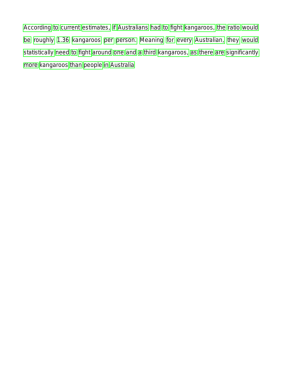

⠠⠁⠠⠉⠠⠉⠠⠕⠗⠙⠊⠝⠛ ⠞⠠⠕ ⠠⠉⠥⠗⠗⠑⠝⠞ ⠑⠠⠎⠞⠊⠍⠁⠞⠑⠠⠎⠠⠚ ⠊⠋ ⠠⠁⠥⠠⠎⠞⠗⠁⠠⠊⠊⠁⠝⠠⠎ ⠓⠁⠙ ⠞⠠⠕ ⠋⠊⠛⠓⠞ ⠅⠁⠝⠛⠁⠗⠠⠕⠠⠕⠠⠎⠠⠚ ⠞⠓⠑ ⠗⠁⠞⠊⠠⠕ ⠠⠺⠠⠕⠥⠠⠊⠙ ⠃⠑ ⠗⠠⠕⠥⠛⠓⠠⠊⠽ ⠇⠠⠃⠃⠲ ⠅⠁⠝⠛⠁⠗⠠⠕⠠⠕⠠⠎ ⠏⠑⠗ ⠏⠑⠗⠠⠎⠠⠕⠝⠲ ⠠⠍⠑⠁⠝⠊⠝⠛ ⠋⠠⠕⠗ ⠑⠠⠧⠑⠽ ⠠⠁⠥⠠⠎⠞⠗⠁⠠⠊⠊⠁⠝⠠⠚ ⠞⠓⠑⠽ ⠠⠺⠠⠕⠥⠠⠊⠙ ⠠⠎⠞⠁⠞⠊⠠⠎⠞⠊⠠⠉⠁⠠⠊⠠⠊⠽ ⠝⠑⠑⠙ ⠞⠠⠕ ⠋⠊⠛⠓⠞ ⠁⠗⠠⠕⠥⠝⠙ ⠠⠕⠝⠑ ⠁⠝⠙ ⠁ ⠞⠓⠊⠗⠙ ⠅⠁⠝⠛⠁⠗⠠⠕⠠⠕⠠⠎⠠⠚ ⠁⠠⠎ ⠞⠓⠑⠗⠑ ⠁⠗⠑ ⠠⠎⠊⠛⠝⠊⠋⠊⠠⠉⠁⠝⠞⠠⠊⠽ ⠍⠠⠕⠗⠑ ⠅⠁⠝⠛⠁⠗⠠⠕⠠⠕⠠⠎ ⠞⠓⠁⠝ ⠏⠑⠠⠕⠏⠠⠊⠑ ⠊⠝ ⠠⠁⠥⠠⠎⠞⠗⠁⠠⠊⠊⠁
File 'output/document_1.txt' created successfully!
--> ACCOrding tO Current eStimateSJ if AuStraIianS had tO fight kangarOOSJ the ratiO WOuId be rOughIy lBb. kangarOOS per perSOn. Meaning fOr eVey AuStraIianJ they WOuId StatiStiCaIIy need tO fight arOund One and a third kangarOOSJ aS there are SignifiCantIy mOre kangarOOS than peOpIe in AuStraIia


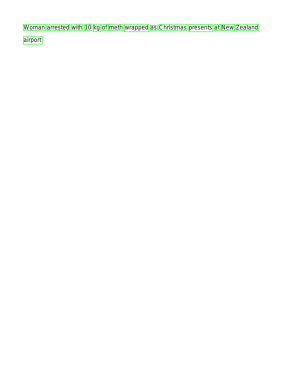

⠠⠺⠠⠕⠍⠁⠝ ⠁⠗⠗⠑⠠⠎⠞⠑⠙ ⠠⠺⠊⠞⠓ ⠇⠠⠕ ⠅⠛ ⠠⠕⠋ ⠍⠑⠞⠓ ⠠⠺⠗⠁⠏⠏⠑⠙ ⠁⠠⠎ ⠠⠉⠓⠗⠊⠠⠎⠞⠍⠁⠠⠎ ⠏⠗⠑⠠⠎⠑⠝⠃ ⠁⠞ ⠠⠝⠑⠠⠺ ⠠⠵⠑⠁⠠⠊⠁⠝⠙ ⠁⠊⠗⠏⠠⠕⠞
File 'output/document_2.txt' created successfully!
--> WOman arreSted With lO kg Of meth Wrapped aS ChriStmaS preSenb at NeW ZeaIand airpOt


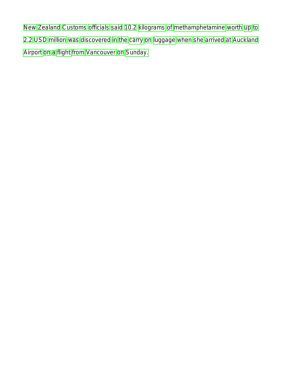

In [ ]:
from helperFunctions.brailleConversion import run_braille_conversion

image_paths = [f"data/test/document_{i}.png" for i in range(1, 21)]
output_path = "output/"

predicted_texts = []

for img_path in image_paths: 
    output_filePath = os.path.join(output_path, img_path.split('/')[-1].split('.')[0] + '.txt')
    img = read_image(img_path)
    text = extract(img)
    predicted_texts.append(text)
    
    run_braille_conversion(text, output_filePath) # save the text in braille format to output location
    
    print('-->', text)


## Spell checking with SymSpell

Symspell performs a spell checking on the OCR'ed text and correct text based on its dictionary database.

In [ ]:
sym_spell = SymSpell(max_dictionary_edit_distance=2, prefix_length=7)
dictionary_path = pkg_resources.resource_filename("symspellpy", "frequency_dictionary_en_82_765.txt")
sym_spell.load_dictionary(dictionary_path, term_index=0, count_index=1)

input_term = text
result = sym_spell.word_segmentation(input_term)
print('The corrected text:',result.corrected_string)

## CER score

Please run using the `compute_CER.py` file instead.

In [18]:
print(predicted_texts)
# import compute_CER from CER.py located in helperFunctions/
from helperFunctions.computeCER import compute_CER

# Load the text file
ground_truth_file = "helperFunctions/groundTruth.txt"
with open(ground_truth_file, 'r', encoding='utf-8') as file:
    lines = file.readlines()

for idx, line in enumerate(lines):
    if line.strip():  # Ensure the line is not empty
        ground_truth = line.strip()
        if idx < len(predicted_texts):
            predicted_text = predicted_texts[idx]
            print(compute_CER(predicted_text, ground_truth))
        else:
            print(f"No predicted text for line {idx + 1}")

['ACCOrding tO Current eStimateSJ if AuStraIianS had tO fight kangarOOSJ the ratiO WOuId be rOughIy lBb. kangarOOS per perSOn. Meaning fOr eVey AuStraIianJ they WOuId StatiStiCaIIy need tO fight arOund One and a third kangarOOSJ aS there are SignifiCantIy mOre kangarOOS than peOpIe in AuStraIia', 'WOman arreSted With lO kg Of meth Wrapped aS ChriStmaS preSenb at NeW ZeaIand airpOt', 'NeW ZeaIand CuStOmS OfiCiaIS Said lOZ. kiIOgramS Of methamphetamine WOth up tO ZZ. USD miIIiOn WaS diSCOVered in the Carry On Iuggage When She arriVed at AuCkIand AirpOt On a fIight frOm VanCOuVer On Sunday.', 'A Canadian WOman haS been arreSted fOr aIIegedIy atempting tO SmuggIe drugS intO NeW ZeaIandJ by diSguiSing them aS ChriStmaS preSenb.', 'BOrder COIIieS are high energy WOrking dOgS that Were hiStOriCaIIy bred tO herd IiVeStOCk On farmS in Great BritainJ aCCOrding tO the AmeriCan BOrder COIIie ASSOCiatiOn Or ABCA. TOdayJ yOu Can StiII find BOrder COIIieS herding On farmSJ but they are aISO pOpuIar f